In [606]:
import numpy as np
import pandas as pd

import scipy

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

import urllib
import urllib.request
from urllib.request import urlopen
from bs4 import BeautifulSoup

In [452]:
url = "http://www.imdb.com/chart/top"
soup = BeautifulSoup(urlopen(url).read(), "html.parser")
results = soup.find_all("td", attrs={"class":"titleColumn"})

In [453]:
def make_soup(url):
    thepage = urllib.request.urlopen(url)
    soupdata = BeautifulSoup(thepage, "html.parser")
    return soupdata

In [454]:
uid = [x.find("a")["href"].split("/")[2] for x in results]

In [456]:
title = []
release = []
rated = []
duration = []
genre = []
rating = []
votes = []

for item in uid:
    film = make_soup("http://www.imdb.com/title/" + item)
    movieTitle = film.find(attrs={"itemprop":"name"}).text.strip()[:-7]
    title.append(movieTitle)
    movieRelease = film.find(attrs={"itemprop":"datePublished"})["content"]
    release.append(movieRelease)
#     movieRated = [x.attrs.get("content") for x in film.select("div.subtext meta[itemprop=contentRating]")]
#     rated.append(movieRated)
    movieDuration = film.find(attrs={"itemprop":"duration"}).text.strip()
    duration.append(movieDuration)
    movieGenre = film.find(attrs={"itemprop":"genre"}).text.strip()
    genre.append(movieGenre)
    movieRating = film.find(attrs={"itemprop":"ratingValue"}).text.strip()
    rating.append(movieRating)
    movieVotes = film.find(attrs={"itemprop":"ratingCount"}).text.strip()
    votes.append(movieVotes)

In [469]:
imdb = pd.DataFrame(columns = ["Rank","Title","Release","Duration (Min)","Genre","Rating","Votes"])
imdb["Rank"] = list(range(1,251))
imdb["Title"] = title
imdb["Release"] = release
# imdb["Rated"] = rated
imdb["Duration (Min)"] = duration
imdb["Genre"] = genre
imdb["Rating"] = rating
imdb["Votes"] = votes

In [357]:
# imdb.head()

,Rank,Title,Release,Rated,Duration,Genre,Rating,Votes
0,1,The Shawshank Redemption,1994-10-14,[R],2h 22min,Crime,9.3,"1,756,937"
1,2,The Godfather,1972-03-24,[R],2h 55min,Crime,9.2,"1,199,880"
2,3,The Godfather: Part II,1974-12-20,[R],3h 22min,Crime,9.0,"824,021"
3,4,The Dark Knight,2008-07-18,[PG-13],2h 32min,Action,9.0,"1,739,999"
4,5,12 Angry Men,1957-04,[APPROVED],1h 36min,Crime,8.9,"471,389"


In [470]:
imdb.head()

,Rank,Title,Release,Duration (Min),Genre,Rating,Votes
0,1,The Shawshank Redemption,1994-10-14,2h 22min,Crime,9.3,"1,757,030"
1,2,The Godfather,1972-03-24,2h 55min,Crime,9.2,"1,199,943"
2,3,The Godfather: Part II,1974-12-20,3h 22min,Crime,9.0,"824,068"
3,4,The Dark Knight,2008-07-18,2h 32min,Action,9.0,"1,740,117"
4,5,12 Angry Men,1957-04,1h 36min,Crime,8.9,"471,437"


In [471]:
# Convert Release to datetime64
imdb["Release"] = imdb["Release"].astype("datetime64")

In [530]:
imdb["Release"] = pd.to_datetime(imdb["Release"]).dt.year

In [472]:
# Format Duration for conversion 
imdb["Duration (Min)"] = imdb["Duration (Min)"].str.replace("h ", ":")
imdb["Duration (Min)"] = imdb["Duration (Min)"].str.replace("h", ":0")
imdb["Duration (Min)"] = imdb["Duration (Min)"].str.replace("min", "")

In [473]:
# Convert Duration to minutes
time = imdb["Duration (Min)"].str.split(":")
length = len(time)
minutes = []
for i in range(length):
    runtime = int(time[i][0]) * 60 + int(time[i][1])
    minutes.append(runtime)

In [474]:
imdb["Duration (Min)"] = minutes

In [475]:
# Convert Rating to float
imdb["Rating"] = imdb["Rating"].astype(float)

In [476]:
# Format Votes for conversion
imdb["Votes"] = imdb["Votes"].str.replace(",","")

In [477]:
# Convert Votes to int64
imdb["Votes"] = imdb["Votes"].astype(int)

In [478]:
imdb.head()

,Rank,Title,Release,Duration (Min),Genre,Rating,Votes
0,1,The Shawshank Redemption,1994-10-14,142,Crime,9.3,1757030
1,2,The Godfather,1972-03-24,175,Crime,9.2,1199943
2,3,The Godfather: Part II,1974-12-20,202,Crime,9.0,824068
3,4,The Dark Knight,2008-07-18,152,Action,9.0,1740117
4,5,12 Angry Men,1957-04-01,96,Crime,8.9,471437


In [533]:
imdb.to_csv('imdb.csv', encoding='utf-8')

In [496]:
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline

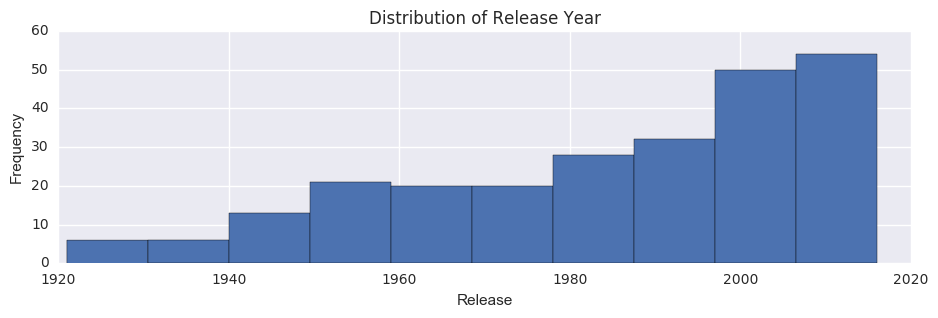

In [546]:
imdb["Release"].plot(kind='hist', figsize = (11,3))
plt.title('Distribution of Release Year')
plt.xlabel("Release")

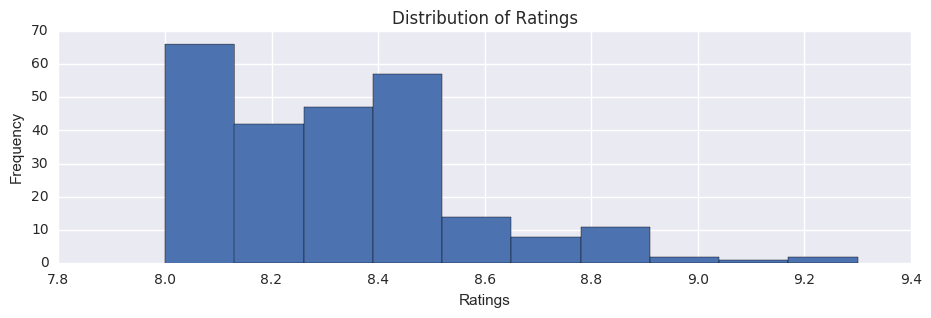

In [547]:
imdb["Rating"].plot(kind='hist', figsize = (11,3))
plt.title('Distribution of Ratings')
plt.xlabel("Ratings")

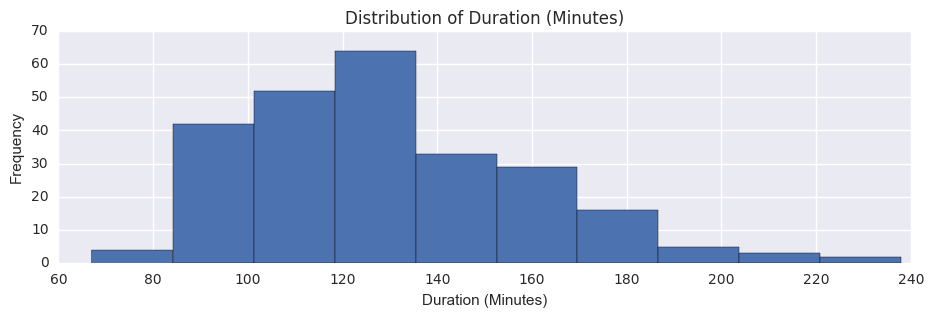

In [548]:
imdb["Duration (Min)"].plot(kind='hist', figsize = (11,3))
plt.title('Distribution of Duration (Minutes)')
plt.xlabel("Duration (Minutes)")

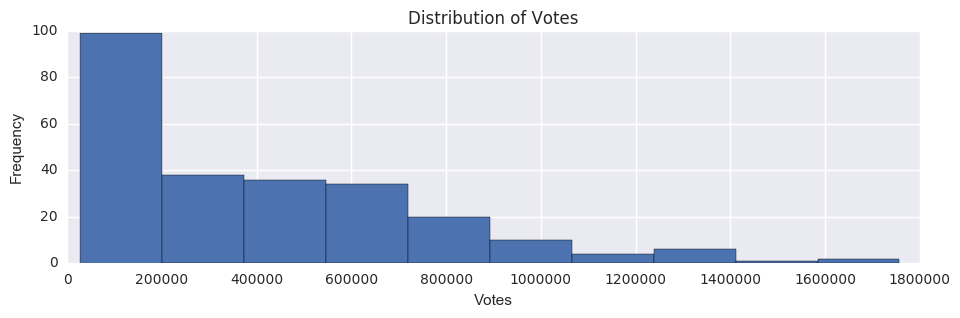

In [549]:
imdb["Votes"].plot(kind='hist', figsize = (11,3))
plt.title('Distribution of Votes')
plt.xlabel("Votes")

In [491]:
genres = imdb.Genre.value_counts()
genres

Drama        70
Crime        44
Action       30
Comedy       30
Adventure    27
Biography    19
Animation    17
Mystery       5
Horror        3
Western       3
Film-Noir     1
Sci-Fi        1
Name: Genre, dtype: int64

In [575]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.grid_search import GridSearchCV

In [570]:
# define the target atribute as movies that scored 8.8 or above

In [557]:
imdb['Top Rating'] = imdb['Rating'].apply(lambda x: 1 if x >= 8.8 else 0)

In [562]:
X = imdb[["Votes","Release","Duration (Min)"]]
Y = imdb['Top Rating']
y = imdb["Rating"]

In [563]:
def cross_val(model):
    scores = cross_val_score(model, X, Y, cv=5, n_jobs=-1)
    return scores.mean(), scores.std()

In [564]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

dt = DecisionTreeClassifier()

In [565]:
dt.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [566]:
cross_val(dt)

(0.92430732292917173, 0.038104845231379803)

In [567]:
bdt = BaggingClassifier(DecisionTreeClassifier())
cross_val(bdt)

(0.94038575430172067, 0.040830354328229866)

In [571]:
# GridSearch
params = {'max_depth' : [3,5,10,15, None],
    'min_samples_split' : [2,3,4],
          'criterion' : ['gini', 
                        'entropy'],
}

gsdt = GridSearchCV(dt, params, cv=5)
gsdt.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 3, 4], 'max_depth': [3, 5, 10, 15, None], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)>

In [572]:
gsbdt = GridSearchCV(bdt, params, cv=5)
gsbdt.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=5, error_score='raise',
       estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, ...n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 3, 4], 'max_depth': [3, 5, 10, 15, None], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)>

In [573]:
# DecisionTreeRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [576]:
dtr = DecisionTreeRegressor(max_depth=5)

In [577]:
dtr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [578]:
dtr.score(X_train, y_train)

0.70550694126669766

In [579]:
y_pred = dtr.predict(X_test)

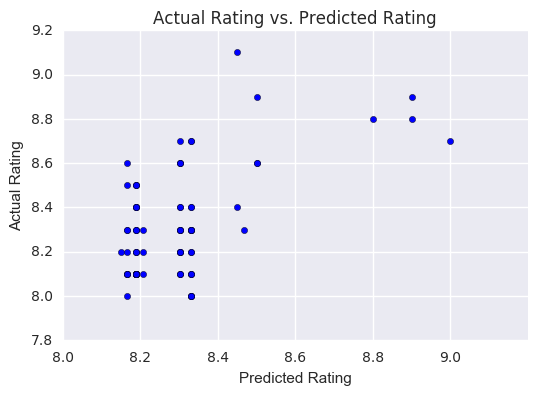

In [580]:
plt.scatter(x=y_pred, y=y_test)

plt.xlabel("Predicted Rating")
plt.ylabel("Actual Rating")
plt.title("Actual Rating vs. Predicted Rating")
plt.show()

In [581]:
params_reg = {'max_depth' : [3,5,10,15, None],
    'min_samples_split' : [2,3,4],
          'splitter' : ['best', 
                        'random'],
}

In [582]:
dtrgs = GridSearchCV(dtr, params_reg, cv=5)

In [583]:
dtrgs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 3, 4], 'max_depth': [3, 5, 10, 15, None], 'splitter': ['best', 'random']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [584]:
dtrgs.best_score_

0.28808372193145859

In [585]:
from sklearn.linear_model import ElasticNet

en = ElasticNet()
params_en = {'alpha' : np.logspace(-2,0,20),
         'l1_ratio' : np.logspace(-2,0,20),
         'normalize' : [True, False],
         'fit_intercept' : [True, False]}

engs = GridSearchCV(en, params_en, cv=5)

In [586]:
net_ = engs.fit(X_train, y_train)

In [587]:
net_.best_score_

0.28399677714731597

In [588]:
# RandomForestsRegressor
rf = RandomForestRegressor()

In [589]:
params_rf = {
    'n_estimators' : [5,10,15,20],
    'max_depth' : [3,5,10,15, None],
    'bootstrap' : [True, False]
}
rfgs = GridSearchCV(rf, params_rf, cv=5)

In [593]:
rfgs_fit = rfgs.fit(X_train, y_train)

In [602]:
y_pred_rf = rf.predict(X_test)
rf.score(X_train, y_train)

0.90460664531519797

In [603]:
rfgs.score(X_train, y_train)

0.72824648925306346

In [604]:
rfgs.best_score_

0.42418213012003392

In [601]:
rf.fit(X_train, y_train)
pd.DataFrame({'feature':X_test.columns, 'importance':rf.feature_importances_})

,feature,importance
0,Votes,0.623974
1,Release,0.238695
2,Duration (Min),0.137332


In [607]:
# ExtraTreesRegressor
et = ExtraTreesRegressor()
params_et = {
    'n_estimators' : [5,10,15,20],
    'max_depth' : [3,5,10,15, None],
    'bootstrap' : [True, False]
}
etgs = GridSearchCV(et, params_et, cv=5)
etgs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 5, 10, 15, None], 'bootstrap': [True, False], 'n_estimators': [5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [608]:
etgs.best_score_

0.80473906636883707